In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

import sys

In [2]:
import random_forest_model as rfm
import load_data as ld
import evan_data_cleaning as edc
import FEngineer as fe

### Data Loading

In [3]:
sys.path.append('../minicomp')
raw_data = ld.load_raw_data()
train_ = raw_data['train.csv']
store_ = raw_data['store.csv']
test = raw_data['test.csv']

test.csv
store.csv
train.csv


/home/schulung/anaconda3/envs/minicomp/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3242: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


### Data Cleaning

In [4]:
store = edc.clean_store(store_)
#train = edc.clean_train(train_)
test = edc.clean_train(test)

test = edc.fill_fast(test,'Sales')
test = edc.fill_fast(test,'Customers')
merged_csvs_test = edc.store_train_merge(store,test)

In [5]:

train = edc.clean_train(train_)

train = edc.fill_fast(train,'Sales')
train = edc.fill_fast(train,'Customers')
merged_csvs = edc.store_train_merge(store,train)

### Feature Engineering

In [6]:
fe_merge = fe.FEngineer(merged_csvs)

In [7]:
merged_csvs_test = fe.FEngineer(merged_csvs_test)

### Train - Validation -Split

In [8]:
X_train, X_test, y_train, y_test = rfm.split_train_valid(fe_merge)

### Baseline

In [9]:
#baseline
#compare to simplest baseline
baseline_simple = np.empty_like(y_test)
baseline_simple[:]=train['Sales'].mean()
#baseline_simple= baseline_simple.fill(train['Sales'].mean())
error_baseline_simple = rfm.rmse(y_test.values,baseline_simple)
error_baseline_simple

63.16566610856383

## Models
### Random Forest

In [10]:
#Hyperparameters
n_estimators = 1000
max_depth = 15 # change variance
max_features = 10 #(sqrt)

In [11]:
rfr, prediction, prediction_train = rfm.rfm_fit(X_train, X_test, y_train, y_test,n_estimators,max_depth, max_features)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    3.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.1s


In [13]:
#prepare test 
target_TEST = merged_csvs_test['Sales']
features_TEST = merged_csvs_test.drop('Sales',axis=1)
prediction_TEST_rf = rfr.predict(features_TEST.values)


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    3.4s finished


In [15]:
#Error
error_test = rfm.rmse (target_TEST.values, prediction_TEST_rf)
error_train = rfm.rmse (y_train.values,prediction_train)

print(error_test)
print(error_train)

10.73017732709097
6.923552843862355


### XGBoost

In [16]:
#Hyperparameters
n_estimators = 200
max_depth = 10 # change variance
max_features = 10 #(sqrt)

In [17]:
xgb_model ,pred, pred_train = rfm.xgboost(X_train, X_test, y_train, y_test,n_estimators,max_depth, max_features)


/home/schulung/anaconda3/envs/minicomp/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[16:26:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [18]:
prediction_TEST_xg = xgb_model.predict(features_TEST)


In [19]:
#Errors
error_test_xgb = rfm.rmse (target_TEST.values, prediction_TEST_xg)
error_train_xgb = rfm.rmse (y_train.values,pred_train)

print(error_test_xgb)
print(error_train_xgb)

8.872011025502292
5.564394774153441


### Plots: predictions of different models over real data

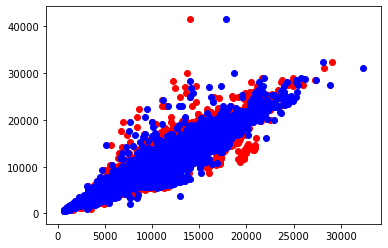

In [21]:
plt.scatter(prediction_TEST_rf,target_TEST,color='red')
plt.scatter(prediction_TEST_xg,target_TEST,color='blue')
plt.show()

### Plot Feature Importance

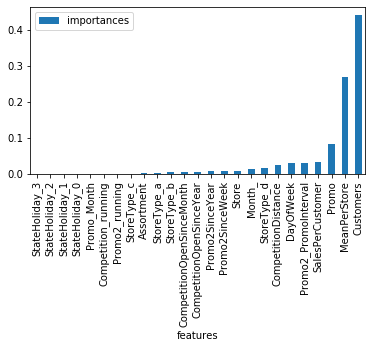

In [22]:
home_mod = os.path.join(os.environ['HOME'], 'minicomp', 'raw-data')
rfm.plot_feature_importances(rfr,X_train.columns,home_mod)

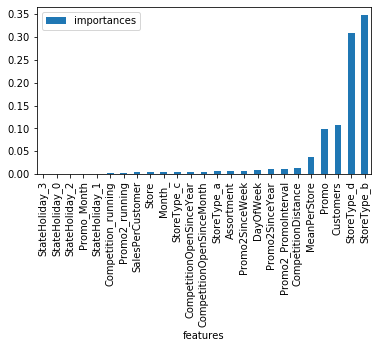

In [23]:
rfm.plot_feature_importances(xgb_model,X_train.columns,home_mod)